In [1]:
!pip install transformers

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from transformers import pipeline

from nltk import sent_tokenize
import nltk
from time import time
import matplotlib.pyplot as plt
import torch

In [3]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
subtitles_paths = sorted(glob("/content/drive/MyDrive/Colab Notebooks/naruto/Subtitles/*.ass"))

In [5]:
subtitles_paths[:5]

['/content/drive/MyDrive/Colab Notebooks/naruto/Subtitles/Naruto Season 1 - 01.ass',
 '/content/drive/MyDrive/Colab Notebooks/naruto/Subtitles/Naruto Season 1 - 02.ass',
 '/content/drive/MyDrive/Colab Notebooks/naruto/Subtitles/Naruto Season 1 - 03.ass',
 '/content/drive/MyDrive/Colab Notebooks/naruto/Subtitles/Naruto Season 1 - 04.ass',
 '/content/drive/MyDrive/Colab Notebooks/naruto/Subtitles/Naruto Season 1 - 05.ass']

In [6]:
scripts = []
episode_num = []
for path in subtitles_paths:

    with open(path,'r') as file:
        lines = file.readlines()
        lines = lines[27:]

        rows = [",".join(line.split(',')[9:]) for line in lines]

    script = " ".join(rows)

    episode = int(path.split('-')[1].split('.')[0].strip())

    scripts.append(script)
    episode_num.append(episode)

In [7]:
import pandas as pd
df = pd.DataFrame.from_dict({'episode': episode_num, 'script': scripts})

def clean_script(script):
    script = script.replace("\\N", ' ')
    script = script.replace("\n", ' ')
    script = script.replace("\"", '')
    return script

df['script'] = df['script'].apply(clean_script)
df.head()

,episode,script
0,1,"A long time ago, a powerful demon fox appeared..."
1,2,"C'mon! Running like a fugitive, Being chased..."
2,3,"C'mon! Running like a fugitive, Being chased..."
3,4,"C'mon! Running like a fugitive, Being chased..."
4,5,"C'mon! Running like a fugitive, Being chased..."


In [8]:
device = 0 if torch.cuda.is_available() else 'cpu'

In [9]:
from transformers import pipeline
theme_classifier = pipeline("zero-shot-classification",
                            model= 'facebook/bart-large-mnli',
                            device= device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [10]:
theme_classifier("I have a problem with my iphone that needs to be resolved asap!",
    candidate_labels=["urgent", "not urgent", "phone", "tablet", "computer"],
    multi_label=False
)

{'sequence': 'I have a problem with my iphone that needs to be resolved asap!',
 'labels': ['urgent', 'phone', 'computer', 'not urgent', 'tablet'],
 'scores': [0.5227577686309814,
  0.45814040303230286,
  0.014264780096709728,
  0.0026850062422454357,
  0.0021520727314054966]}

In [11]:
def get_themes(script):
    script_sentences = sent_tokenize(script)

    # Batch sentences
    script_batches = []
    sentence_batch_size=20
    for index in range(0,len(script_sentences),sentence_batch_size):
        sent = " ".join(script_sentences[index:index+sentence_batch_size])
        script_batches.append(sent)

    # Run model
    candidate_labels = ['friendship','hope', 'sacrifice', 'battle','self development','betrayal','love','dialogue']
    emotion_output = theme_classifier(script_batches,
                       candidate_labels,multi_label=True)

    # Wrangle Output
    emotions={}
    for output in  emotion_output:
        for label, score in zip(output['labels'],output['scores']):
            if label not in emotions:
                emotions[label]=[]
            emotions[label].append(score)

    emotions =  {key:np.mean(np.array(value)) for key,value in emotions.items()}

    return emotions

In [12]:
output_emotions = df['script'].apply(get_themes)

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


In [14]:
emotion_df = pd.DataFrame(output_emotions.tolist())
emotion_df.head()

,dialogue,betrayal,battle,sacrifice,self development,hope,friendship,love
0,0.930826,0.844329,0.731683,0.739767,0.789798,0.316973,0.265458,0.154907
1,0.866817,0.556704,0.602021,0.542227,0.727818,0.357463,0.212669,0.144213
2,0.895714,0.567082,0.736256,0.672057,0.736925,0.350319,0.335128,0.257748
3,0.702058,0.369029,0.652293,0.503009,0.502719,0.216771,0.126632,0.140256
4,0.748091,0.648095,0.705341,0.656423,0.614582,0.265870,0.281858,0.124274


In [15]:
emotion_df.to_pickle('emotion_df.pkl')

In [16]:
emotion_df = emotion_df.sum().reset_index()
emotion_df.columns = ['theme', 'score']
emotion_df.head()

,theme,score
0,dialogue,187.273928
1,betrayal,119.265176
2,battle,149.392427
3,sacrifice,151.176946
4,self development,136.826736


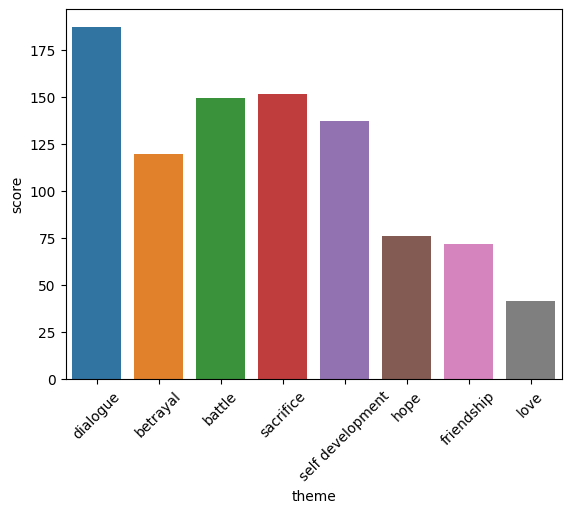

In [18]:
import seaborn as sns
sns.barplot(data=emotion_df, x='theme', y='score', hue='theme', dodge=False)
plt.xticks(rotation=45)
plt.show()